# **1. Import Libraries**

In [3]:
import os
import cv2
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.applications as ap
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.callbacks as cb
from sklearn.metrics import confusion_matrix

import warnings


warnings.filterwarnings('ignore')
os.environ['PYTHONWARNINGS'] = 'ignore'


# **2. Download Dataset**

In [4]:
dataset_path = kagglehub.dataset_download('bhavikjikadara/dog-and-cat-classification-dataset')
print('Data source import complete.')

Data source import complete.


In [5]:
directory = os.path.join(dataset_path, 'PetImages')

In [6]:
os.listdir(directory)

['Dog', 'Cat']

# **3. Load and Preprocessing Data**

In [8]:
images = []
labels = []

try:
  for foldr in os.listdir(directory):
    for filee in os.listdir(os.path.join(directory, foldr)):
      images.append(os.path.join(foldr, filee))
      labels.append(foldr)
        
except Exception as e:
  print(f'Error: {e}')

In [11]:
df = pd.DataFrame({
    'Images': images,
    'Labels': labels
    })

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24998 entries, 0 to 24997
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Images  24998 non-null  object
 1   Labels  24998 non-null  object
dtypes: object(2)
memory usage: 390.7+ KB


In [12]:
df

,Images,Labels
0,Dog/7981.jpg,Dog
1,Dog/6234.jpg,Dog
2,Dog/1269.jpg,Dog
3,Dog/3863.jpg,Dog
4,Dog/6241.jpg,Dog
...,...,...
24993,Cat/8152.jpg,Cat
24994,Cat/3361.jpg,Cat
24995,Cat/2599.jpg,Cat
24996,Cat/10035.jpg,Cat


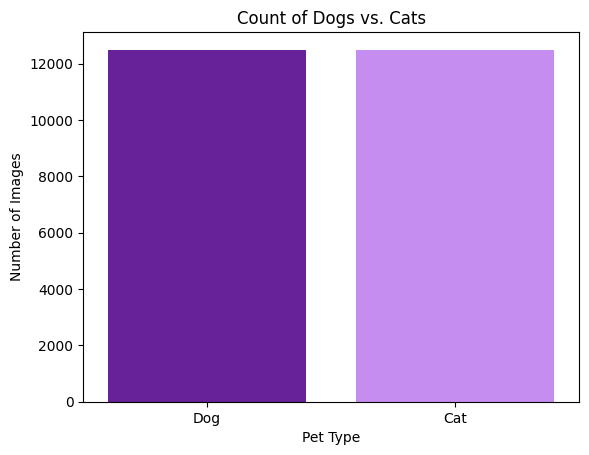

In [14]:
colors = ['#6A0DAD', '#C77DFF']  

sns.countplot(x='Labels', data=df, palette=colors)
plt.title('Count of Dogs vs. Cats')
plt.xlabel('Pet Type')
plt.ylabel('Number of Images')
plt.show()


# **4. EDA**

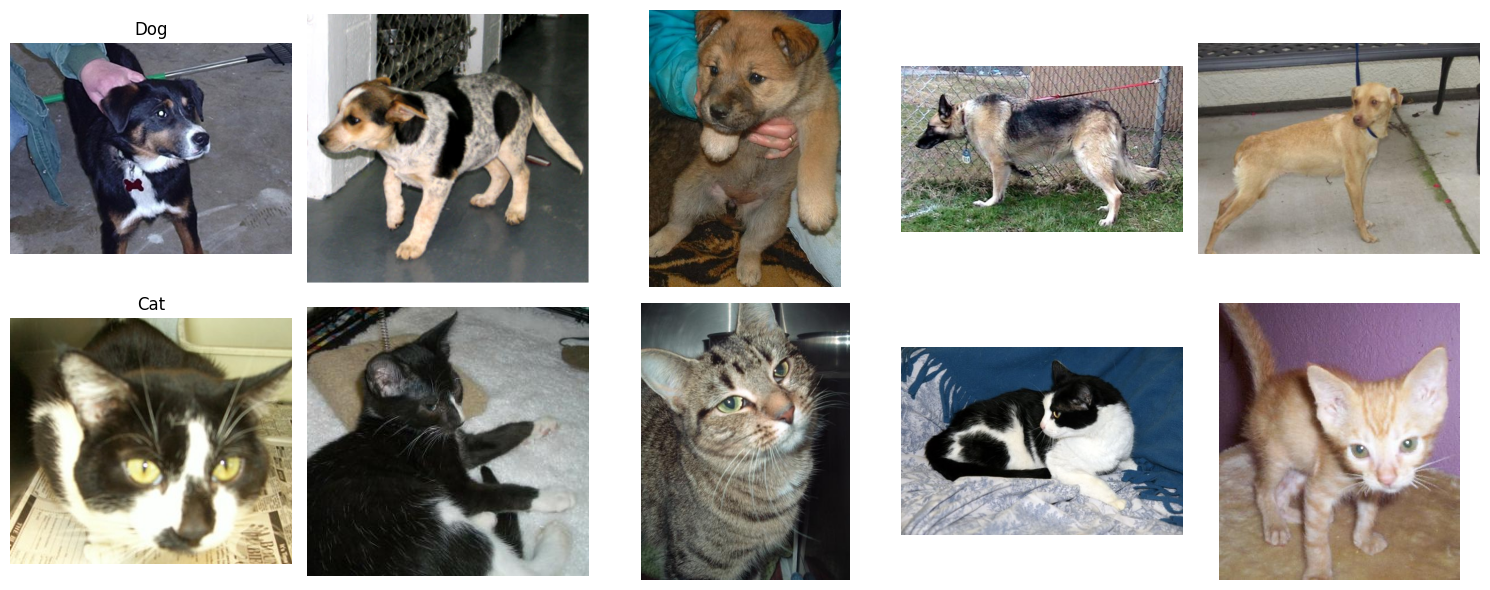

In [40]:
import math

images_per_label = 5
labels = df['Labels'].unique()
rows = len(labels)
cols = images_per_label

plt.figure(figsize=(cols * 3, rows * 3))

for row, label in enumerate(labels):
    samples = df[df['Labels'] == label].sample(images_per_label)

    for col, (_, sample) in enumerate(samples.iterrows()):
        img_path = os.path.join(directory, sample['Images'])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(rows, cols, row * cols + col + 1)
        plt.imshow(img)
        plt.title(label if col == 0 else "")
        plt.axis('off')

plt.tight_layout()
plt.show()


# **5. Data Splitting**

In [22]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Labels'])

# **6. Data Augmentation**

In [23]:
trainimgen = ImageDataGenerator( 
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.2
    )

train_data = trainimgen.flow_from_dataframe(
    dataframe=train_df,
    directory=directory,
    x_col='Images',
    y_col='Labels',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=16,
)

Found 19998 validated image filenames belonging to 2 classes.


In [25]:
testimgen = ImageDataGenerator()


test_data = testimgen.flow_from_dataframe(
    dataframe=test_df,
    directory=directory,
    x_col='Images',
    y_col='Labels',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=16,
    shuffle=False,
)

Found 5000 validated image filenames belonging to 2 classes.


# **7. Model Definition**

In [26]:

processing = ap.ResNet50(weights='imagenet', include_top=False)

for layer in processing.layers[:5]:
    layer.trainable = False

Model = Sequential(
    [
        processing,
        GlobalAveragePooling2D(),

        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ]
)

I0000 00:00:1765622504.318489      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [27]:
Model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, None, None,     │    23,587,712 │
│                                 │ 2048)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,145,281 (92.11 MB)

 Trainable params: 24,082,561 (91.87 MB)

 Non-trainable params: 62,720 (245.00 KB)

# **8. Model Optimization Using Early Stopping**

In [33]:
callback = cb.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
Model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# **9. Model Training:**

In [34]:
Model.fit(
    train_data,
    epochs=5,
    validation_data=test_data,
    callbacks=[callback]
    )

Epoch 1/5


I0000 00:00:1765622720.217062     223 service.cc:148] XLA service 0x7c43c00a7d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765622720.217843     223 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765622724.989975     223 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1250 ━━━━━━━━━━━━━━━━━━━━ 19:01:21 55s/step - accuracy: 0.4375 - loss: 0.7884

I0000 00:00:1765622743.220893     223 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 602s 438ms/step - accuracy: 0.9461 - loss: 0.1326 - val_accuracy: 0.9734 - val_loss: 0.0815
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 302s 242ms/step - accuracy: 0.9742 - loss: 0.0659 - val_accuracy: 0.9798 - val_loss: 0.0518
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 257s 206ms/step - accuracy: 0.9815 - loss: 0.0495 - val_accuracy: 0.9832 - val_loss: 0.0445
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 244s 195ms/step - accuracy: 0.9855 - loss: 0.0428 - val_accuracy: 0.9840 - val_loss: 0.0438
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 251s 201ms/step - accuracy: 0.9864 - loss: 0.0378 - val_accuracy: 0.9810 - val_loss: 0.0574


# **10. Model Evaluation:**

In [35]:
Model.evaluate(test_data)

313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9851 - loss: 0.0463


[0.043771252036094666, 0.984000027179718]

In [36]:

preds = Model.predict(test_data)

preds_classes = (preds > 0.5).astype(int).flatten()

313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step


# **11. Confusion Matrix**

<Axes: >

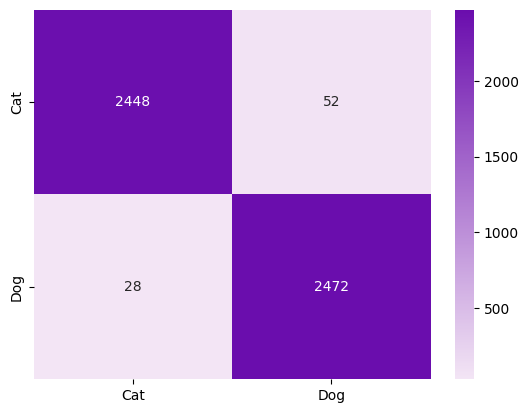

In [38]:
from matplotlib.colors import LinearSegmentedColormap

purple_cmap = LinearSegmentedColormap.from_list(
    'purple_grad', ['#F3E5F5', '#6A0DAD']
)

sns.heatmap(cm, annot=True, fmt='d', cmap=purple_cmap,
            xticklabels=list(test_data.class_indices.keys()),
            yticklabels=list(test_data.class_indices.keys()))


# **12. Model Saving:**

In [39]:
Model.save("Resnet50 model.keras")